# Chicago Park District Events - Neighborhood Analysis

This notebook analyzes events by neighborhood. It loads the pre-processed dataset with neighborhoods already assigned.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import imageio
from matplotlib.animation import FuncAnimation
import os

warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

print("Libraries loaded successfully!")


Libraries loaded successfully!


## 1. Load Dataset with Neighborhoods


In [2]:
# Load the dataset with neighborhoods
neighborhood_file = '../Chicago_Park_District_-_Event_Permits_With_Neighborhoods.csv'

if not os.path.exists(neighborhood_file):
    raise FileNotFoundError(f"File not found: {neighborhood_file}. Please run event_visualization_analysis.ipynb first to generate neighborhoods.")

df = pd.read_csv(neighborhood_file)

# Convert date columns - pandas can auto-detect ISO format (YYYY-MM-DD) and US format (MM/DD/YYYY)
df['Reservation Start Date'] = pd.to_datetime(df['Reservation Start Date'], errors='coerce')
df['Reservation End Date'] = pd.to_datetime(df['Reservation End Date'], errors='coerce')

# Filter to only rows with valid coordinates and neighborhoods
df_coords = df[(df['Latitude'].notna()) & (df['Longitude'].notna()) & (df['Neighborhood'].notna())].copy()

print(f"Dataset loaded: {len(df)} total rows")
print(f"Rows with coordinates and neighborhoods: {len(df_coords)} ({len(df_coords)/len(df)*100:.2f}%)")
print(f"\nDate range: {df_coords['Reservation Start Date'].min()} to {df_coords['Reservation Start Date'].max()}")
print(f"\nUnique neighborhoods: {df_coords['Neighborhood'].nunique()}")

# Prepare temporal columns
df_coords['Year'] = df_coords['Reservation Start Date'].dt.year
df_coords['Month'] = df_coords['Reservation Start Date'].dt.month
df_coords['YearMonth'] = df_coords['Reservation Start Date'].dt.to_period('M')

df_coords.head()


Dataset loaded: 133799 total rows
Rows with coordinates and neighborhoods: 131923 (98.60%)

Date range: 2012-01-07 00:00:00 to 2025-12-31 00:00:00

Unique neighborhoods: 187


,Requestor,Organization,Park Number,Park/Facility Name,Reservation Start Date,Reservation End Date,Event Type,Event Description,Permit Status,Year,Month,Latitude,Longitude,Geocoding Query,Geocoding Method,Neighborhood,YearMonth
0,Esteban Arriaga,--,24.0,Grant Lower Hutchinson Diamond 10,2024-09-12,2024-09-12,Administrative Reservation - Internal Hold PARKS,esteban,Tentative,2024,9,41.882727,-87.618730,"Grant Park, Chicago, IL, USA",regex,Loop,2024-09
1,Michelle Baldwin Welles Park,--,110.0,Welles Grove 03,2017-07-30,2017-07-30,Administrative Reservation - Internal Hold PARKS,Welles Nature Play Area Construction,Approved,2017,7,41.962269,-87.686525,"Welles Park, Chicago, IL, USA",regex,Ravenswood Gardens,2017-07
2,Martina Brkljacic,--,123.0,Riis Picnic Grove 1,2024-06-05,2024-06-05,Permit - Event 2 Cluster 1,HSA Belmont Kindergarten Promotion Ceremony (N...,On Hold,2024,6,41.926076,-87.781860,"Riis Park, Chicago, IL, USA",regex,Belmont Cragin,2024-06
3,Allie Fabris,--,1074.0,Wrightwood Picnic Grove Greenview-Wright,2024-05-30,2024-05-30,Permit - Event 1 Cluster 2,SJS Picnic (Non-exclusive Use),On Hold,2024,5,41.928011,-87.666778,"Wrightwood Park, Chicago, IL, USA",regex,West DePaul,2024-05
4,Michelle Baldwin Welles Park,--,110.0,Welles Pool,2015-06-30,2015-06-30,Administrative Reservation - Internal Hold PARKS,Day Camp at Welles,Approved,2015,6,41.962787,-87.686899,"Welles Pool, Chicago, IL, USA",full_facility_name,Ravenswood Gardens,2015-06


## 2. Analyze Events by Neighborhood


Top 20 Neighborhoods by Total Events:
Neighborhood
Loop                  18782
Uptown                16252
Fifth City             7239
Park Manor             6091
Near West Side         4747
Near South Side        3629
Washington Park        3448
New East Side          3398
Lincoln Park           3393
West Town              3162
Douglas                2649
Woodlawn               2630
Irving Park            2620
Albany Park            2346
South Shore            2287
Ravenswood Gardens     1971
Humboldt Park          1710
Edgewater Beach        1611
North Center           1449
Magnificent Mile       1420
dtype: int64


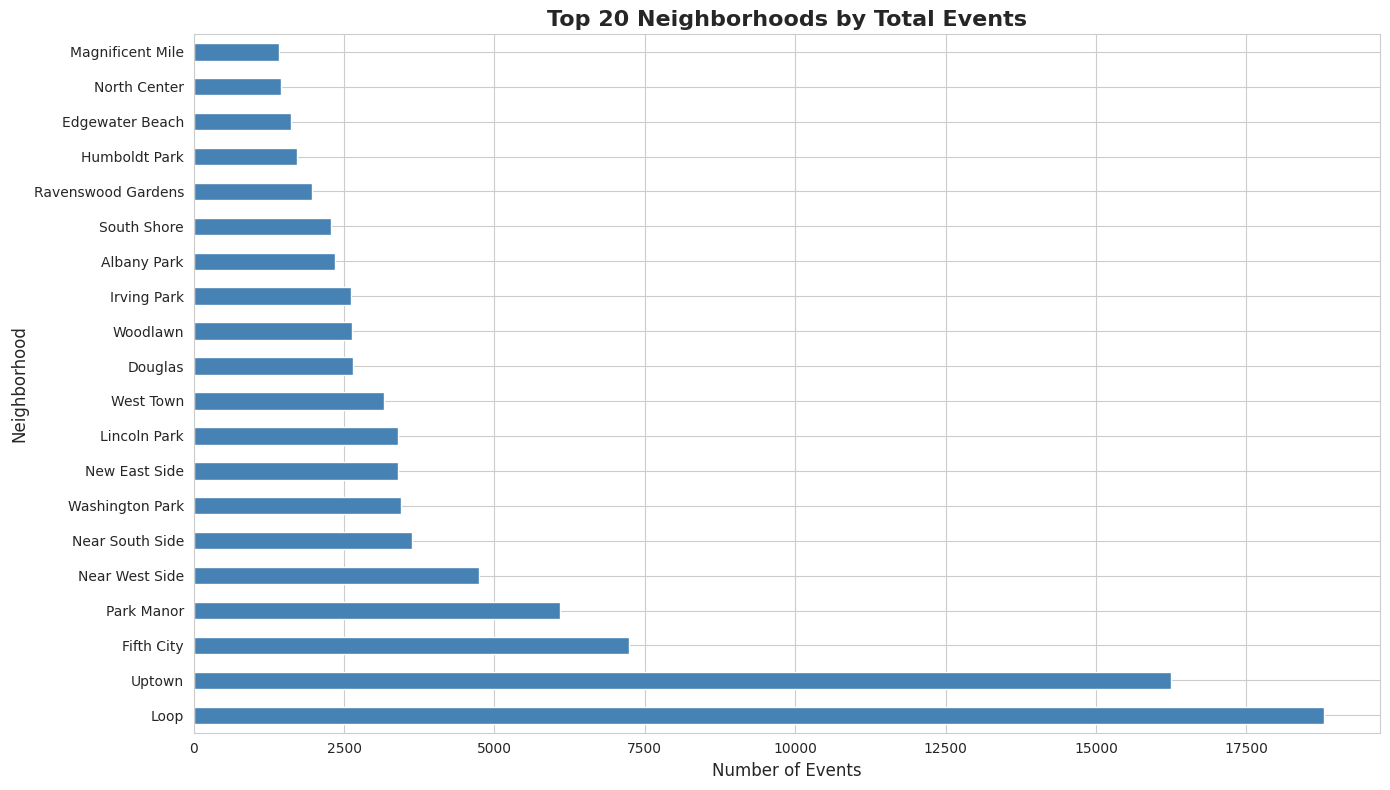

In [3]:
# Events by neighborhood
events_by_neighborhood = df_coords.groupby('Neighborhood').size().sort_values(ascending=False)

print("Top 20 Neighborhoods by Total Events:")
print(events_by_neighborhood.head(20))

# Plot top neighborhoods
plt.figure(figsize=(14, 8))
events_by_neighborhood.head(20).plot(kind='barh', color='steelblue')
plt.title('Top 20 Neighborhoods by Total Events', fontsize=16, fontweight='bold')
plt.xlabel('Number of Events', fontsize=12)
plt.ylabel('Neighborhood', fontsize=12)
plt.tight_layout()
plt.show()


## 3. Events Over Time by Neighborhood


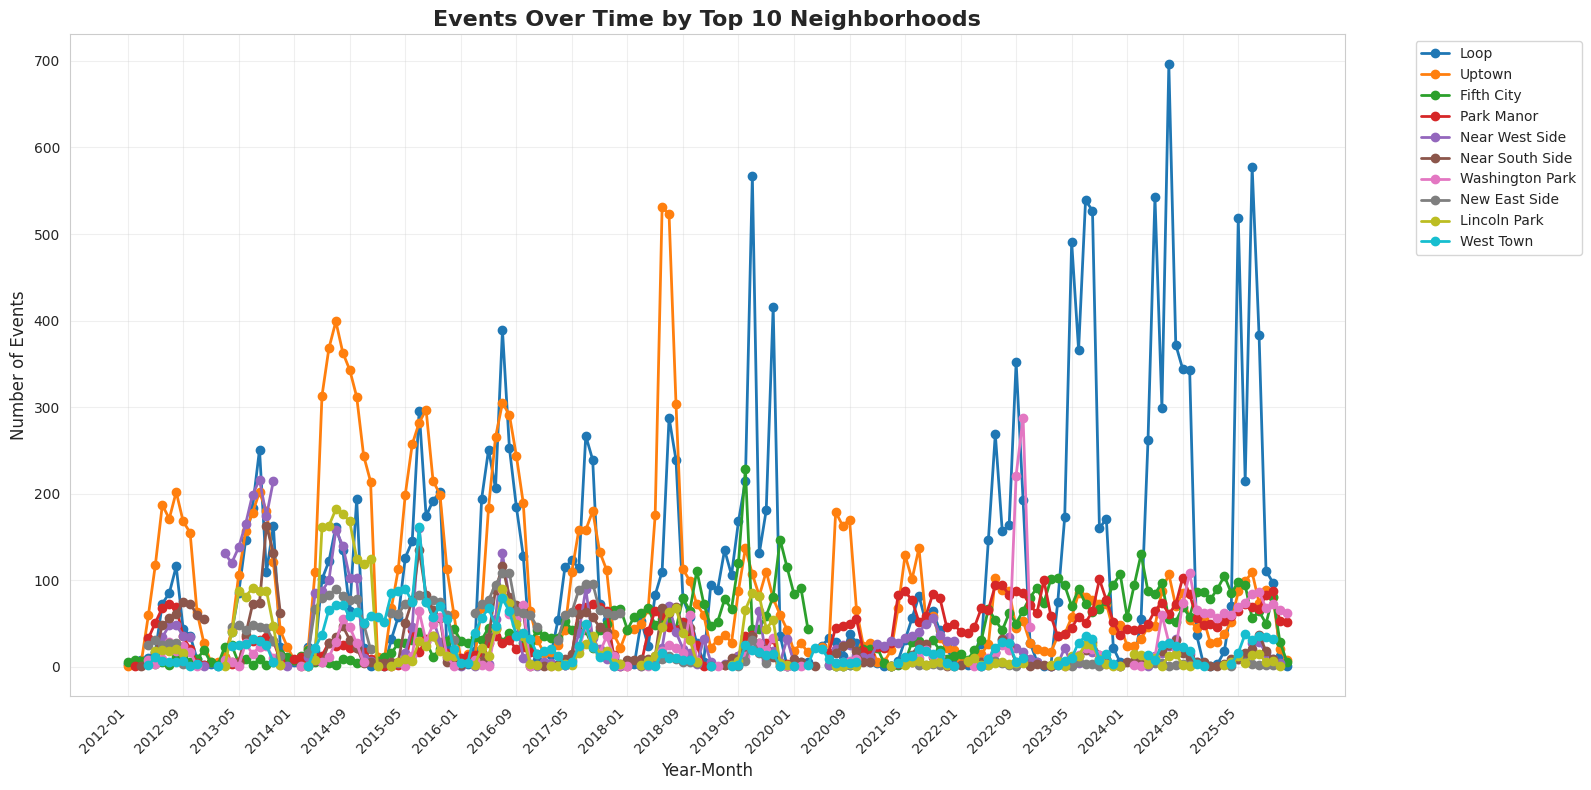

In [4]:
# Events by neighborhood and month
events_by_neighborhood_month = df_coords.groupby(['Neighborhood', 'YearMonth']).size().reset_index(name='EventCount')

# Get top neighborhoods (ensure we calculate this fresh)
events_by_neighborhood = df_coords.groupby('Neighborhood').size().sort_values(ascending=False)
top_neighborhoods = events_by_neighborhood.head(10).index.tolist()

events_top_neighborhoods = events_by_neighborhood_month[events_by_neighborhood_month['Neighborhood'].isin(top_neighborhoods)]

# Pivot for easier plotting
pivot_data = events_top_neighborhoods.pivot(index='YearMonth', columns='Neighborhood', values='EventCount')
pivot_data.index = pivot_data.index.astype(str)

plt.figure(figsize=(16, 8))
for neighborhood in top_neighborhoods:
    if neighborhood in pivot_data.columns:
        plt.plot(pivot_data.index, pivot_data[neighborhood], marker='o', label=neighborhood, linewidth=2)

plt.title('Events Over Time by Top 10 Neighborhoods', fontsize=16, fontweight='bold')
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Number of Events', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
# Show only some x-axis labels to avoid crowding
n = len(pivot_data.index)
step = max(1, n // 20)
plt.xticks(range(0, n, step), pivot_data.index[::step], rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 4. Create Animated Visualization (GIF) - Events per Month per Neighborhood


In [5]:
# Prepare data for animation
df_coords_clean = df_coords[df_coords['Neighborhood'].notna()].copy()

# Group by neighborhood and month
events_by_neighborhood_month = df_coords_clean.groupby(['Neighborhood', 'YearMonth']).size().reset_index(name='EventCount')

# Get all unique months sorted
all_months = sorted(df_coords_clean['YearMonth'].unique())

# Create pivot table
pivot_table = events_by_neighborhood_month.pivot(index='Neighborhood', columns='YearMonth', values='EventCount').fillna(0)

# Sort neighborhoods by total events
neighborhood_totals = pivot_table.sum(axis=1).sort_values(ascending=False)
pivot_table = pivot_table.loc[neighborhood_totals.index]

print(f"Prepared data for {len(all_months)} months and {len(pivot_table)} neighborhoods")
print(f"Date range: {all_months[0]} to {all_months[-1]}")


Prepared data for 168 months and 187 neighborhoods
Date range: 2012-01 to 2025-12


Creating animation frames...
Created 168 frames
Creating GIF...
Animation saved to: ../chicago_events_by_neighborhood_animated.gif
GIF shows events per month for top 20 neighborhoods


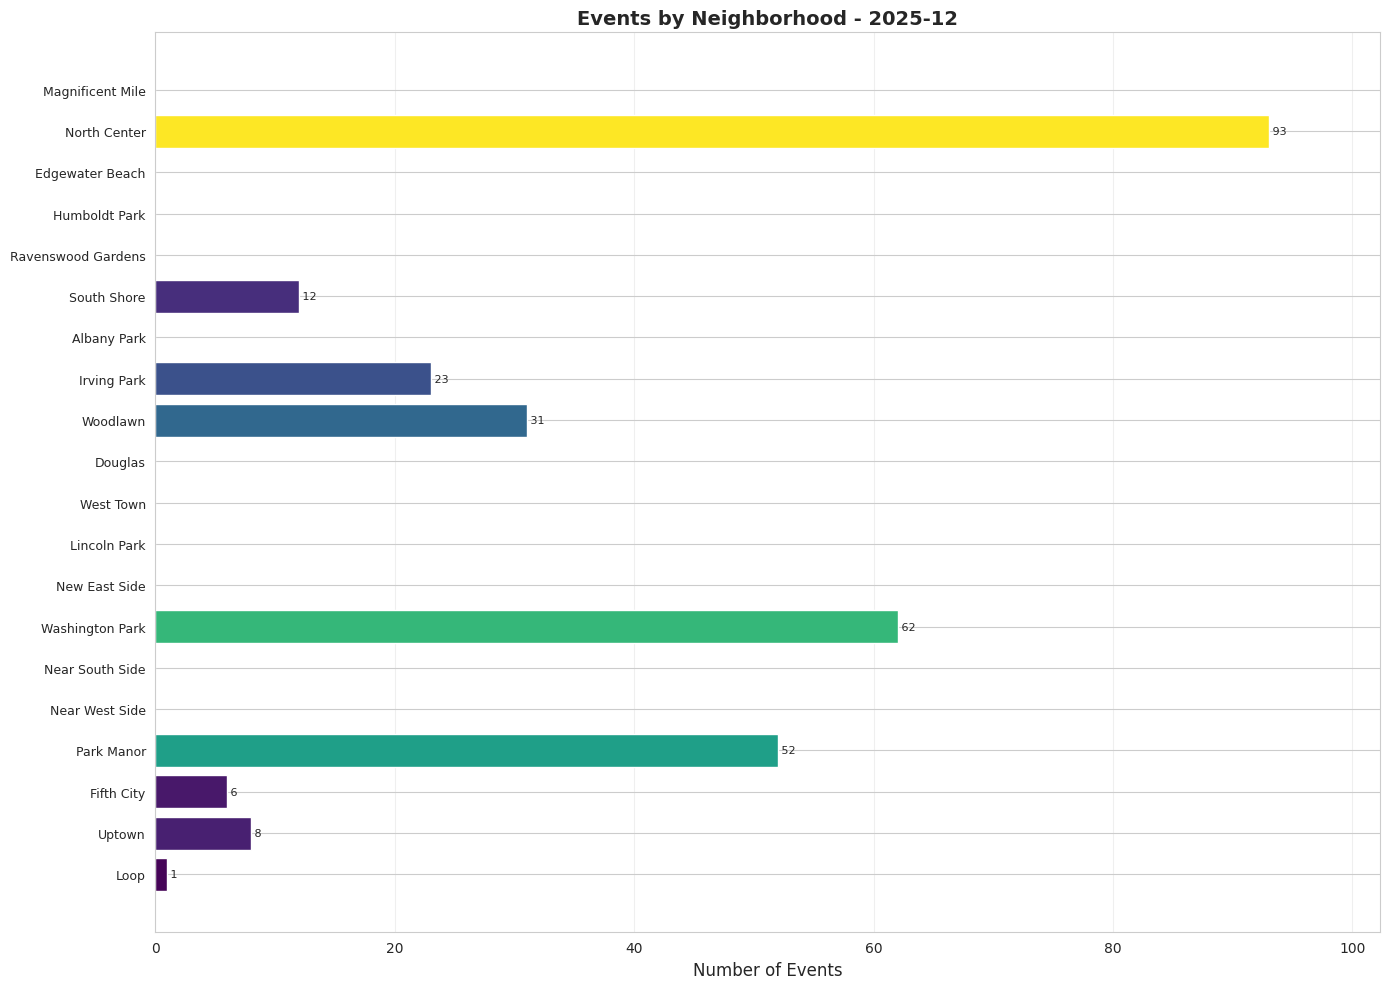

In [8]:
# Create animated bar chart showing events per month per neighborhood
def create_animation_frame(month, pivot_table, ax, max_neighborhoods=20):
    """Create a single frame of the animation."""
    ax.clear()
    
    # Get data for this month
    month_str = str(month)
    if month not in pivot_table.columns:
        data = pd.Series(0, index=pivot_table.index.head(max_neighborhoods))
    else:
        data = pivot_table[month].head(max_neighborhoods)
    
    # Create horizontal bar chart
    if data.max() > 0:
        colors = plt.cm.viridis(data / data.max())
    else:
        colors = ['lightgray'] * len(data)
    
    bars = ax.barh(range(len(data)), data.values, color=colors)
    
    # Customize plot
    ax.set_yticks(range(len(data)))
    ax.set_yticklabels(data.index, fontsize=9)
    ax.set_xlabel('Number of Events', fontsize=12)
    ax.set_title(f'Events by Neighborhood - {month_str}', fontsize=14, fontweight='bold')
    ax.set_xlim(0, max(data.max() * 1.1, 10))
    ax.grid(axis='x', alpha=0.3)
    
    # Add value labels on bars
    for i, (idx, val) in enumerate(data.items()):
        if val > 0:
            ax.text(val, i, f' {int(val)}', va='center', fontsize=8)
    
    return bars

# Create figure
fig, ax = plt.subplots(figsize=(14, 10))

# Create animation
print("Creating animation frames...")
frames = []
num_months = len(all_months)  # Limit to 24 months for file size

for i, month in enumerate(all_months[:num_months]):
    bars = create_animation_frame(month, pivot_table, ax, max_neighborhoods=20)
    fig.tight_layout()
    
    # Save frame as image
    frame_path = f'../temp_frame_{i:03d}.png'
    fig.savefig(frame_path, dpi=80, bbox_inches='tight')
    frames.append(frame_path)

print(f"Created {len(frames)} frames")

# Create GIF
print("Creating GIF...")
gif_path = '../chicago_events_by_neighborhood_animated.gif'
try:
    images = [imageio.imread(frame) for frame in frames]
    imageio.mimwrite(gif_path, images, duration=20, loop=0)  # 0.5 seconds per frame
    print(f"Animation saved to: {gif_path}")
except Exception as e:
    print(f"Error creating GIF: {e}")
    print("Make sure imageio and pillow are installed")

# Clean up temporary frames
for frame in frames:
    if os.path.exists(frame):
        try:
            os.remove(frame)
        except:
            pass

print(f"GIF shows events per month for top 20 neighborhoods")


In [9]:
# Alternative: Create cumulative events animation
heatmap_data = pivot_table.head(20).T  # Top 20 neighborhoods, transpose for month x neighborhood

# Create figure for animation
fig, ax = plt.subplots(figsize=(16, 10))

# Normalize for color mapping
vmax = max(heatmap_data.sum(axis=0).max() if len(heatmap_data) > 0 else 1, 1)

def animate(frame):
    """Update the chart for each frame."""
    ax.clear()
    
    if frame < len(all_months[:36]):  # Limit to 36 months
        month = all_months[frame]
        month_str = str(month)
        
        # Get cumulative data up to this month
        data_to_month = heatmap_data.iloc[:frame+1].sum()
        
        # Create bar chart
        if len(data_to_month) > 0 and data_to_month.max() > 0:
            bars = ax.barh(range(len(data_to_month)), data_to_month.values, 
                          color=plt.cm.viridis(data_to_month.values / vmax))
            
            ax.set_yticks(range(len(data_to_month)))
            ax.set_yticklabels(data_to_month.index, fontsize=9)
            ax.set_xlabel('Cumulative Events', fontsize=12)
            ax.set_title(f'Cumulative Events by Neighborhood (up to {month_str})', 
                        fontsize=14, fontweight='bold')
            ax.set_xlim(0, data_to_month.max() * 1.1)
            ax.grid(axis='x', alpha=0.3)
            
            # Add value labels
            for i, (neighborhood, val) in enumerate(data_to_month.items()):
                if val > 0:
                    ax.text(val, i, f' {int(val)}', va='center', fontsize=8)

# Create animation (limit to reasonable number of frames)
num_frames = len(all_months)  # Max 36 months (3 years)

try:
    ani = FuncAnimation(fig, animate, frames=num_frames, interval=500, repeat=True)
    
    # Save as GIF
    gif_path2 = '../chicago_events_cumulative_animated.gif'
    ani.save(gif_path2, writer='pillow', fps=2)  # 2 frames per second
    print(f"Cumulative animation saved to: {gif_path2}")
    plt.close(fig)
except Exception as e:
    print(f"Error creating cumulative animation: {e}")
    print("Make sure pillow is installed: pip install pillow")


Cumulative animation saved to: ../chicago_events_cumulative_animated.gif


## 5. Additional Analysis


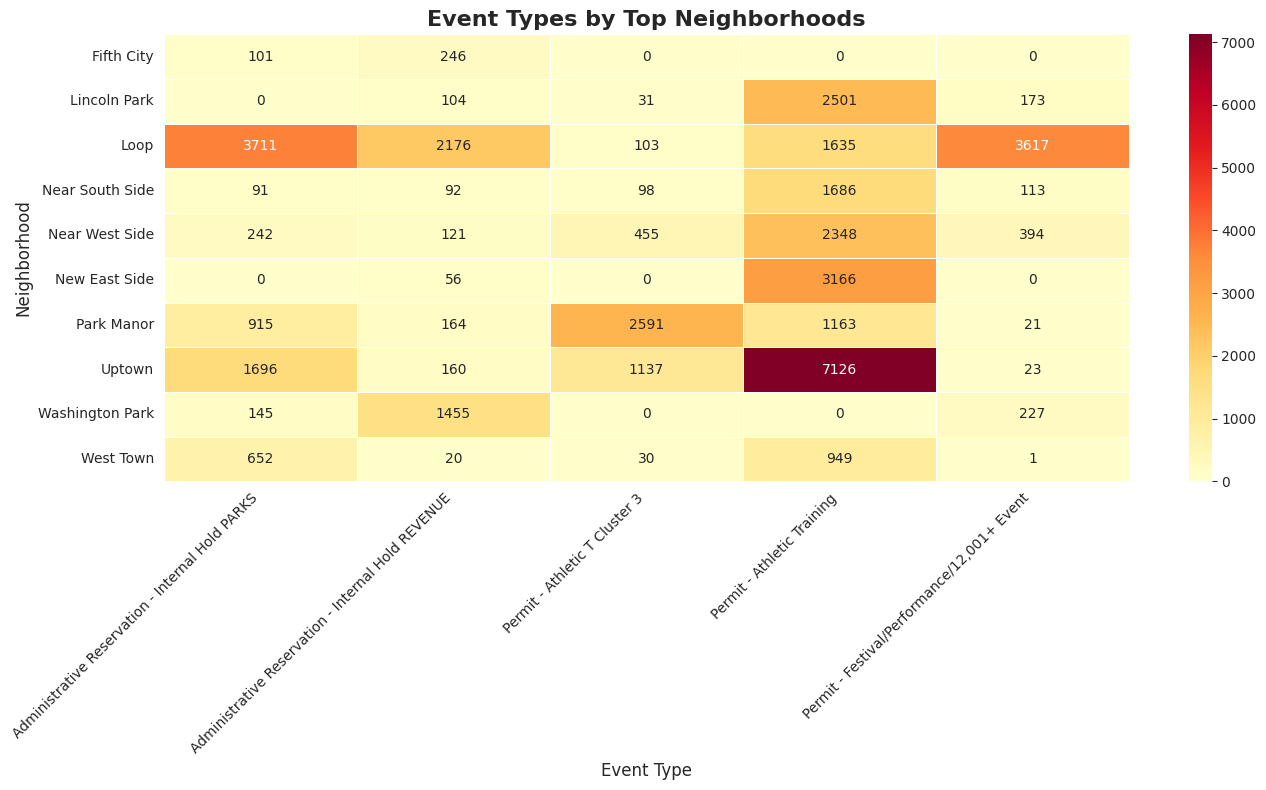

In [10]:
# Event types by neighborhood
events_by_type_neighborhood = df_coords.groupby(['Neighborhood', 'Event Type']).size().reset_index(name='Count')
top_neighborhoods_list = events_by_neighborhood.head(10).index.tolist()

# Filter to top neighborhoods
events_top = events_by_type_neighborhood[events_by_type_neighborhood['Neighborhood'].isin(top_neighborhoods_list)]

# Get top event types
top_event_types = df_coords['Event Type'].value_counts().head(5).index.tolist()
events_top_types = events_top[events_top['Event Type'].isin(top_event_types)]

# Pivot for heatmap
pivot_heatmap = events_top_types.pivot(index='Neighborhood', columns='Event Type', values='Count').fillna(0)

plt.figure(figsize=(14, 8))
sns.heatmap(pivot_heatmap, annot=True, fmt='.0f', cmap='YlOrRd', linewidths=0.5)
plt.title('Event Types by Top Neighborhoods', fontsize=16, fontweight='bold')
plt.xlabel('Event Type', fontsize=12)
plt.ylabel('Neighborhood', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


<Figure size 1200x800 with 0 Axes>

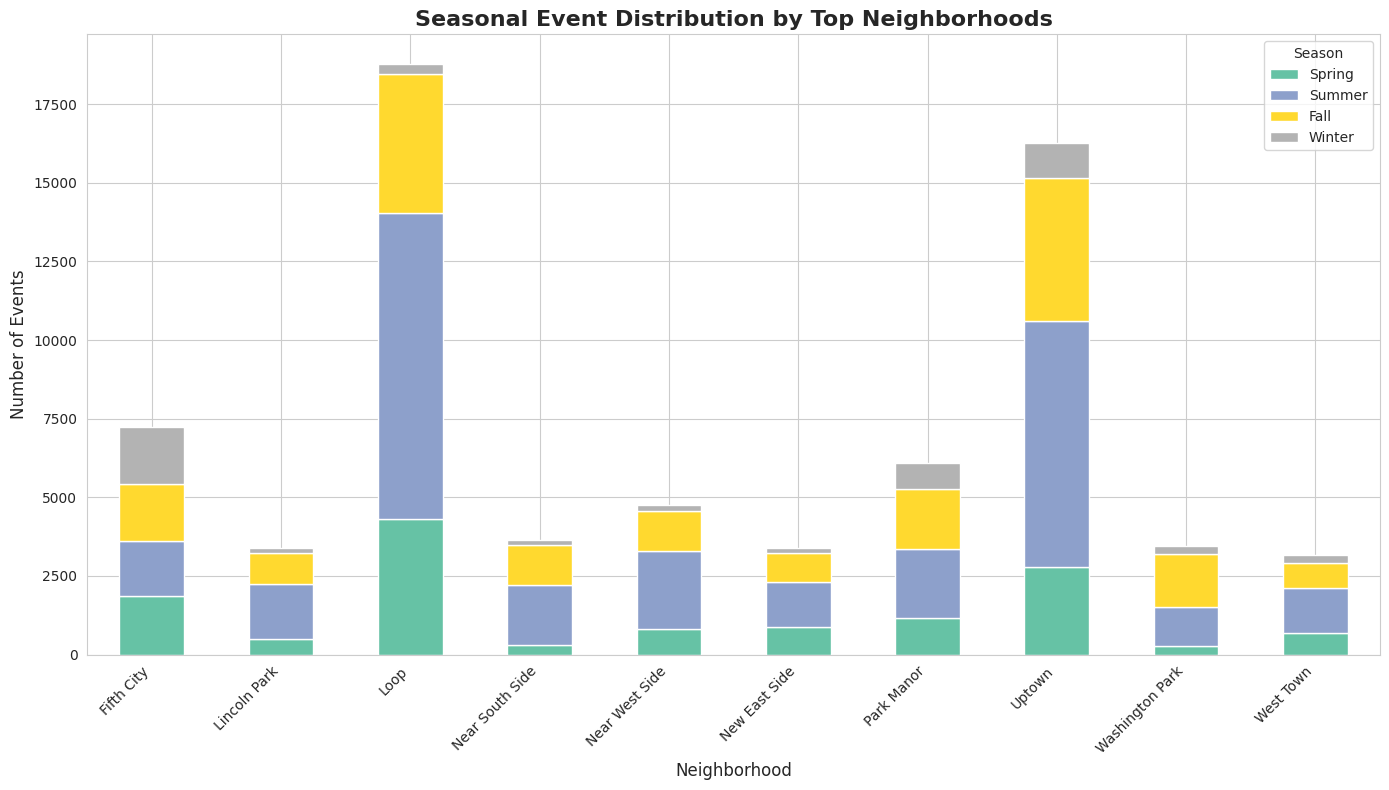

In [11]:
# Seasonal patterns by neighborhood
df_coords['Season'] = df_coords['Month'].map({
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Fall', 10: 'Fall', 11: 'Fall'
})

events_by_season_neighborhood = df_coords.groupby(['Neighborhood', 'Season']).size().reset_index(name='Count')
top_neighborhoods_list = events_by_neighborhood.head(10).index.tolist()
events_season_top = events_by_season_neighborhood[events_by_season_neighborhood['Neighborhood'].isin(top_neighborhoods_list)]

pivot_season = events_season_top.pivot(index='Neighborhood', columns='Season', values='Count').fillna(0)

# Reorder seasons
season_order = ['Spring', 'Summer', 'Fall', 'Winter']
pivot_season = pivot_season[[s for s in season_order if s in pivot_season.columns]]

plt.figure(figsize=(12, 8))
pivot_season.plot(kind='bar', stacked=True, colormap='Set2')
plt.title('Seasonal Event Distribution by Top Neighborhoods', fontsize=16, fontweight='bold')
plt.xlabel('Neighborhood', fontsize=12)
plt.ylabel('Number of Events', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Season')
plt.tight_layout()
plt.show()


## Summary

✅ **Analysis Completed:**
1. Events distribution by neighborhood
2. Events over time by neighborhood
3. Animated visualizations (monthly and cumulative)
4. Event types by neighborhood
5. Seasonal patterns by neighborhood

**Output Files:**
- `chicago_events_by_neighborhood_animated.gif` - Monthly events animation
- `chicago_events_cumulative_animated.gif` - Cumulative events animation
